In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
print(os.listdir("../input/LANL-Earthquake-Prediction"))
path = "../input/LANL-Earthquake-Prediction/"

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['sample_submission.csv', 'train.csv', 'test']


In [2]:
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

读取train的行数，查看数据格式如何

In [3]:
train = pd.read_csv(path + 'train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [4]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [5]:
print(len(train))

629145480


In [6]:
train.shape

(629145480, 2)

In [7]:
# pandas doesn't show us all the decimals
pd.options.display.precision = 15

In [8]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


test中每个文件的数据量是15000   
train 切割出4000多个seg_id，每个seg_id作为索引

In [9]:
# Create a training file with simple derived features

rows = 150000
segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                      columns=["ave", "std", "max", "min"])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                      columns=["time_to_failure"])

In [10]:
segments

4194

In [11]:
X_train.head()

,ave,std,max,min
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


In [12]:
y_train.head()

,time_to_failure
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [13]:
import numpy as np
mat = np.array([1+2j, 3+4j, 5+6j])
print("mat=", mat)
print("实部", np.real(mat))
print("虚部", np.imag(mat))

mat= [1.+2.j 3.+4.j 5.+6.j]
实部 [1. 3. 5.]
虚部 [2. 4. 6.]


> 傅里叶变换实际上是对一个周期无限大的函数进行傅里叶变换    
> 将一个时域非周期的连续信号，转换为一个在频域非周期的连续信号

In [14]:
# 增加 ave std max min等特征
from tqdm import tqdm
for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segments*rows+rows]
    x = seg["acoustic_data"].values
    y = seg["time_to_failure"].values[-1]
    
    y_train.loc[segment, "time_to_failure"] = y
    
    X_train.loc[segment, "ave"] = x.mean()
    X_train.loc[segment, "std"] = x.std()
    X_train.loc[segment, "max"] = x.max()
    X_train.loc[segment, "min"] = x.min()

100%|██████████| 4194/4194 [2:44:30<00:00,  2.35s/it]


In [15]:
def add_trend_feature(arr, abs_values=False):
    """
    增加趋势特征, 线性回归
    arr: 'acoustic_data'
    """
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    # coef_为线性回归的w权重
    # intercept_为w0 类似偏度
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    """
    计算标准 STA / LTA
    STA: 捕捉地震信号的时间窗
    LTA: 衡量时间窗内的平均噪声
    """
    # 以一维数组累加
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [16]:
def create_features(seg_id, seg, X):
    """
    增加新特征
    seg_id: id
    seg: train[150000]
    X: X_train shape->(segments,4)
    """
    xc = pd.Series(seg['acoustic_data'].values)
    # 傅里叶变换
    zc = np.fft.fft(xc)
    # mean std max min
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    
    # 实步的统计值
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    # 虚步的统计值
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    # 实步的部分数据统计值
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    # 计算离散差值的平均值
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]).values)[0])
    # 绝对值的最大最小值
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    # 标准差
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    # 平均值
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    # 最小值
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    # 最大值
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    # 最大除以绝对值最小
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    # 最大值减去绝对值最小
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    # 大于500的长度
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    # 累加
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]).values)[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]).values)[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]).values)[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]).values)[0])
    # 分位数
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    # 绝对值的分位数
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    # 获得趋势特征
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    # 平均绝对偏差
    X.loc[seg_id, 'mad'] = xc.mad()
    # 偏度
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    # 偏度
    X.loc[seg_id, 'skew'] = xc.skew()
    # 中位数
    X.loc[seg_id, 'med'] = xc.median()
    # Hilbert变换 信号里面经常的时域变换
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    # 函数计算移动平均值和卷积：hann函数提供了一个sym关键字参数，如果设置其为0的话，那么将产生一个N+1点的hann窗函数，然后取其前N个数，这样得到的窗函数适合于周期信号
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    # 计算标准 STA / LTA
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    # rolling特征
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    # 指数加权滑动（ewm）, 指数加权滑动平均（ewma）
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    # 移动平均
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    # 分位数之差
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    # 分位数
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    # 从两条尾部修整分布后返回数组的平均值。
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    # 窗口滑动获取部分数据
    for windows in [10, 100, 1000]:
        # rolling 特征
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        
        # roll 特征的差值特征
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        # rolling 的特征的绝对值最大值
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [17]:
for seg_id in tqdm_notebook(range(segments)):
    seg = train.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, X_train)

  0%|          | 0/4194 [00:00<?, ?it/s]

In [18]:
X_train.head()

,ave,std,max,min,mean,Rmean,Rstd,Rmax,Rmin,Imean,Istd,Imax,Imin,Rmean_last_5000,Rstd__last_5000,Rmax_last_5000,Rmin_last_5000,Rmean_last_15000,Rstd_last_15000,Rmax_last_15000,Rmin_last_15000,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,std_first_10000,std_last_10000,avg_first_50000,avg_last_50000,avg_first_10000,avg_last_10000,min_first_50000,min_last_50000,min_first_10000,min_last_10000,max_first_50000,max_last_50000,max_first_10000,max_last_10000,max_to_min,max_to_min_diff,count_big,sum,mean_change_rate_first_50000,mean_change_rate_last_50000,mean_change_rate_first_10000,mean_change_rate_last_10000,q95,q99,q05,q01,abs_q95,abs_q99,abs_q05,abs_q01,trend,abs_trend,abs_mean,abs_std,mad,kurt,skew,med,Hilbert_mean,Hann_window_mean,classic_sta_lta1_mean,classic_sta_lta2_mean,classic_sta_lta3_mean,classic_sta_lta4_mean,Moving_average_700_mean,Moving_average_1500_mean,Moving_average_3000_mean,Moving_average_6000_mean,exp_Moving_average_300_mean,exp_Moving_average_3000_mean,exp_Moving_average_30000_mean,MA_700MA_std_mean,MA_700MA_BB_high_mean,MA_700MA_BB_low_mean,MA_400MA_std_mean,MA_400MA_BB_high_mean,MA_400MA_BB_low_mean,MA_1000MA_std_mean,iqr,q999,q001,ave10,ave_roll_std_10,std_roll_std_10,max_roll_std_10,min_roll_std_10,q01_roll_std_10,q05_roll_std_10,q95_roll_std_10,q99_roll_std_10,av_change_abs_roll_std_10,av_change_rate_roll_std_10,abs_max_roll_std_10,ave_roll_mean_10,std_roll_mean_10,max_roll_mean_10,min_roll_mean_10,q01_roll_mean_10,q05_roll_mean_10,q95_roll_mean_10,q99_roll_mean_10,av_change_abs_roll_mean_10,av_change_rate_roll_mean_10,abs_max_roll_mean_10,ave_roll_std_100,std_roll_std_100,max_roll_std_100,min_roll_std_100,q01_roll_std_100,q05_roll_std_100,q95_roll_std_100,q99_roll_std_100,av_change_abs_roll_std_100,av_change_rate_roll_std_100,abs_max_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,av_change_abs_roll_mean_100,av_change_rate_roll_mean_100,abs_max_roll_mean_100,ave_roll_std_1000,std_roll_std_1000,max_roll_std_1000,min_roll_std_1000,q01_roll_std_1000,q05_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,av_change_abs_roll_std_1000,av_change_rate_roll_std_1000,abs_max_roll_std_1000,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,4.519467573700124,5.101106130606765,104.0,-98.0,4.884113333333334,12.000000000000002,2349.811481800189085,732617.0,-20121.154171234855312,-4.365574568510056e-16,1399.854635310395224,23432.719432718040480,-23432.719432718044118,-2.606182613213164,1513.574807585783219,9208.972085564804729,-12837.254225910466630,5.354098198492072,2812.202696607881990,21205.810957063826208,-20121.154171234855312,-0.000080000533337,74836.577199220613693,104.0,0.0,6.488551888989741,3.664663420228340,11.207151110947080,4.361406519310332,4.96210,4.62046,5.1820,4.6756,-98.0,-21.0,-98.0,-16.0,104.0,30.0,104.0,26.0,1.061224460601807,6.0,0.0,732617.0,24942.324635647688410,25002.266464332984469,4981.149551569506912,4983.576120424221699,11.0,18.0,-2.0,-8.0,12.0,20.0,1.0,0.0,-0.000003268299817,-0.000011278536937,5.576566666666666,4.333324673993449,3.263401356800000,33.662481293451094,-0.024061166628209,5.0,7.027028035412705,4.883327023570953,0.920976028914028,0.266087336023126,0.935910825361665,0.808124398212053,4.883593057935697,4.882672085260930,4.880503078210353,4.877772253896385,4.884650448524550,4.887354492458108,4.891813589971528,4.229416497005937,13.342426051947571,-3.575239936076178,4.155806235470404,13.195205528876505,-3.428019413005112,4.288590310584859,4.0,40.00000000000000,-30.0,4.869341666666666,3.507117717076669,2.809071196343591,78.313047018573712,0.421637021353334,1.264911064066753,1.636391694483953,7.226494462892822,15.034220133197648,-0.000001534223484,74737.274401751885307,7

In [19]:
# 标准化
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [20]:
# SVM算法训练预测
svm = NuSVR()
svm.fit(X_train_scaled, y_train.values.flatten())
y_pred = svm.predict(X_train_scaled)

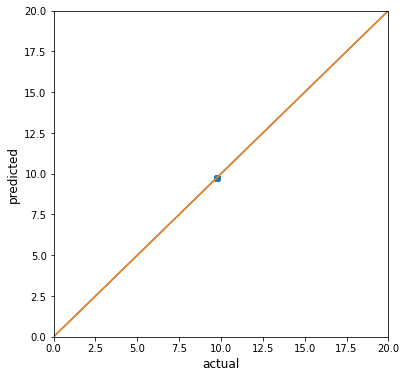

In [21]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train.values.flatten(), y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [22]:
score = mean_absolute_error(y_train.values.flatten(), y_pred)
print(f'Score: {score:0.3f}')

Score: 0.000


In [23]:
submission = pd.read_csv(path + 'sample_submission.csv', index_col='seg_id')

In [24]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


test每个文件名都为seg索引

In [25]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [26]:
for seg_id in X_test.index:
    seg = pd.read_csv(path + "test/" + seg_id + ".csv")
    
    x = seg['acoustic_data'].values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()

In [27]:
for seg_id in tqdm_notebook(X_test.index):
    seg = pd.read_csv(path + 'test/' + seg_id + '.csv')
    create_features(seg_id, seg, X_test)

  0%|          | 0/2624 [00:00<?, ?it/s]

In [28]:
X_test_scaled = scaler.transform(X_test) # 标准化
submission['time_to_failure'] = svm.predict(X_test_scaled)
submission.to_csv('submission.csv')